<a href="https://colab.research.google.com/github/vivekdarji-git/public/blob/master/NMT_RNN_SEQ2SEQ_ATTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN MODEL

* MULTIPLE LSTM ENCODER DECODER LEVELS
* ATTENTION LAYER
* ENG TO SPA TRANSLATIONS



In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# importing libraries

import tensorflow as tf
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import io
import unicodedata
import pickle as pkl
from tensorflow.keras.layers import Layer, LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import backend as K

In [3]:
path_to_dir = 'drive/My Drive/Colab Notebooks/samp_data'
path_to_file = path_to_dir + '/spa.txt'

In [4]:
def to_ascii(s):
  s_ascii = ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')
  return s_ascii

#preprocessing
def preprocess_sentence(w):
  w = to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating a space between a word and the punctuation following it
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r'[^a-zA-Z?.!,¿]+'," ", w) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = w.strip()
  w = '<start> ' + w + ' <end>' # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
  return w

#testing

en_sentence = u'Were there any stars in the sky?'
sp_sentence =  u'¿Había estrellas en el cielo?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> were there any stars in the sky ? <end>
b'<start> \xc2\xbf habia estrellas en el cielo ? <end>'


In [5]:
#clean the sentences
#return wordpairs [ENGLISH, SPANISH]
#create datasets
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='utf-8').read().strip().split('\n')
  en = []
  sp = []
  for line in lines[:num_examples]:
    word_pairs_line = line.split('\t')
    en.append(preprocess_sentence(word_pairs_line[0]))
    sp.append(preprocess_sentence(word_pairs_line[1]))
  return en, sp


en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
#tokenize
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
  return tensor, lang_tokenizer

#tensor  = data / array (think X, y)

In [7]:
def load_datasets(path, num_examples):
  inp_lang, targ_lang = create_dataset(path, num_examples)
  
  inp_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  targ_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return inp_tensor, targ_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
num_examples = 120000 #124000+ is the actual

In [9]:
inp_tensor, targ_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_datasets(path_to_file, num_examples)

#inp_tensor = X_train (all data, before split)
#targ_tensor = y_train(all data, before split)
inp_tensor[0], targ_tensor[0]

(array([ 1, 48,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0], dtype=int32),
 array([  1, 356,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32))

In [10]:
inp_lang_tokenizer, targ_lang_tokenizer

(<keras_preprocessing.text.Tokenizer at 0x7f1da54fc550>,
 <keras_preprocessing.text.Tokenizer at 0x7f1da76520b8>)

In [11]:
max_length_inp = inp_tensor.shape[1] # longest sentence length
max_length_targ = targ_tensor.shape[1] #longest sentence length

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1 #vocab_size_source 
vocab_targ_size = len(targ_lang_tokenizer.word_index)+1 #vocab_size_target 

max_length_inp, max_length_targ, vocab_inp_size, vocab_targ_size


(21, 22, 12256, 23870)

In [12]:
#create train and validation split 80-20

X_train, X_test, y_train, y_test = train_test_split(inp_tensor, targ_tensor, test_size = 0.2)
print(len(X_train), len(y_train), len(X_test), len(y_test))

96000 96000 24000 24000


In [13]:
#testing

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print("Input Language; index to word mapping")
convert(inp_lang_tokenizer, X_train[0])

print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, y_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> tom
20 ----> was
58 ----> here
9 ----> a
312 ----> while
383 ----> ago
3 ----> .
2 ----> <end>
Target Language; index to word mapping
1 ----> <start>
9 ----> tom
357 ----> estuvo
46 ----> aqui
108 ----> hace
15 ----> un
803 ----> rato
3 ----> .
2 ----> <end>


In [14]:
#saving files in pickle
with open(path_to_dir+'/saved pickle/NMT_train_test_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)

with open(path_to_dir+'/saved pickle/NMT_inp_tokenizer.pkl','wb') as f:
  pkl.dump([vocab_inp_size, inp_lang_tokenizer.word_index, inp_lang_tokenizer], f)

with open(path_to_dir+'/saved pickle/NMT_targ_tokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_targ_size, targ_lang_tokenizer.word_index, targ_lang_tokenizer], f)

print("pickle files saved")

pickle files saved


In [15]:
type(X_train)

numpy.ndarray

In [16]:
#Attention class (can be put in a separate py file)


K.clear_session()

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]



In [17]:
#buidling a model

embedding_dim = 256
units = 1024


In [18]:
#ENCODER
encoder_inputs = Input(shape=(max_length_inp,))

# EMBEDDING
enc_emb = Embedding(vocab_inp_size, embedding_dim, trainable = True)(encoder_inputs)

#LSTM 1 
encoder_lstm1 = LSTM(units, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(units, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3 = LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)




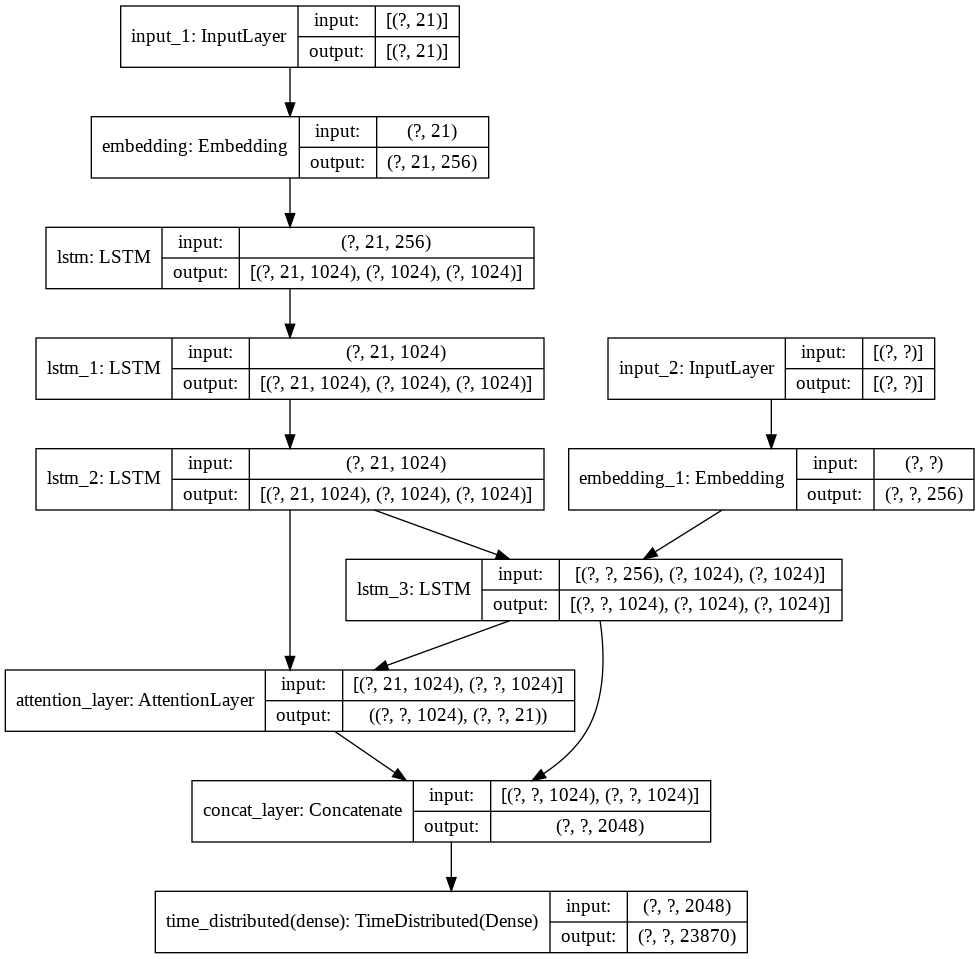

In [19]:
#DECODER

decoder_inputs = Input(shape = (None,))

#EMBEDDING
dec_emb = Embedding(vocab_targ_size, embedding_dim, trainable = True)(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(units, return_sequences=True, return_state = True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h,state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concatenate attn output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer

decoder_dense = TimeDistributed(Dense(vocab_targ_size, activation='softmax'))

decoder_outputs = decoder_dense(decoder_concat_input)

#Define the model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

plot_model(model, to_file = 'train_model.png', show_shapes= True)


In [20]:
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 256)      3137536     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 21, 1024), ( 5246976     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [21]:
#Model Training / teacher forcing
EPOCHS = 50
BATCH_SIZE = 64

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1) #Stop training when a monitored metric has stopped improving.

#training

history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=EPOCHS, 
                    #callbacks=[es],
                    batch_size=BATCH_SIZE,
                    validation_data = ([X_test, y_test[:,:-1]],          
                                       y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/50
1500/1500 [==============================] - 603s 402ms/step - loss: 1.4537 - accuracy: 0.7853 - val_loss: 1.0985 - val_accuracy: 0.8319
Epoch 2/50
1500/1500 [==============================] - 598s 399ms/step - loss: 0.9636 - accuracy: 0.8512 - val_loss: 0.9064 - val_accuracy: 0.8609
Epoch 3/50
1500/1500 [==============================] - 578s 385ms/step - loss: 0.7996 - accuracy: 0.8755 - val_loss: 0.8283 - val_accuracy: 0.8729
Epoch 4/50
1500/1500 [==============================] - 571s 381ms/step - loss: 0.7037 - accuracy: 0.8897 - val_loss: 0.7911 - val_accuracy: 0.8791
Epoch 5/50
1500/1500 [==============================] - 570s 380ms/step - loss: 0.6354 - accuracy: 0.9005 - val_loss: 0.7766 - val_accuracy: 0.8828
Epoch 6/50
1500/1500 [==============================] - 569s 379ms/step - loss: 0.5753 - accuracy: 0.9087 - val_loss: 0.7585 - val_accuracy: 0.8842
Epoch 7/50
1500/1500 [==============================] - 571s 381ms/step - loss: 0.5167 - accuracy: 0.9161 - val_

In [22]:
model_json = model.to_json()
with open(path_to_dir+'/saved pickle/NMT_model.json','w') as json_file:
          json_file.write(model_json)

#serialize weights to hDF5
model.save_weights(path_to_dir+'/saved pickle/NMT_model_weight.h5')
print("Model saved")

Model saved


In [23]:
#Loading the model
json_file = open(path_to_dir+'/saved pickle/NMT_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects = {'AttentionLayer': AttentionLayer})

#Loading the weights
model_loaded.load_weights(path_to_dir+'/saved pickle/NMT_model_weight.h5')

model_loaded.input

[<tf.Tensor 'input_1_1:0' shape=(None, 21) dtype=float32>,
 <tf.Tensor 'input_2_1:0' shape=(None, None) dtype=float32>]

In [24]:
model_loaded.layers

In [25]:
model_loaded.layers[6]

In [26]:
#INFERENCE MODEL

# to predict our output sequences by considering weights from a pre-trained model
# its a model that deduces properties that are learned in training phase and are now used for predicting new sequences


units = units #1024 in our case ( from earlier steps)

#encoder inference
encoder_inputs = model_loaded.input[0] #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output  #loading encoder outputs
 
print(encoder_outputs.shape)

encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])




(None, 21, 1024)


In [27]:
#decoder inference
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_hidden_state_input = Input(shape=(max_length_inp, units))

#Get embeddings for decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)

dec_emb2 = model_loaded.layers[5](decoder_inputs)

#to predict the next word in sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])



(None, None)


In [28]:
#Attention inference

attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concat= model_loaded.layers[9]
decoder_inf_concat = concat([decoder_outputs2, attn_out_inf])

#a dense softmax layer to generate prob dist.
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)


In [29]:
#Final Decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
                      [decoder_outputs2] + [state_h2, state_c2])

In [30]:
#PREDICTIONS

def decode_sequence (input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1,1))

  #chose the start word as the first word of the target sequence

  target_seq[0,0] = targ_lang_tokenizer.word_index['<start>']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
  
    # Sample a token and add the corresponding character to the decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    if sampled_token_index == 0:
      break
    else:
      sampled_token = targ_lang_tokenizer.index_word[sampled_token_index]
    
    if(sampled_token!='<end>'):
      decoded_sentence += ' '+sampled_token
      
    # Exit condition: either hit max length or find stop word.
    if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
        stop_condition = True
    
    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence


In [31]:
def seq2summary(input_seq):
  newString = ''
  for i in input_seq:
    if((i!=0 and i!=targ_lang_tokenizer.word_index['<start>']) and i!= targ_lang_tokenizer.word_index['<end>']):
      newString = newString+targ_lang_tokenizer.index_word[i] + ' '
  return newString

def seq2text(input_seq):
  newString = ''
  for i in input_seq:
    if(i!=0):
      newString = newString + inp_lang_tokenizer.index_word[i] + ' '
  return newString

In [32]:
for i in range(10):  
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_length_inp)))
  print("\n")

Review: <start> tom was impatient to see mary again . <end> 
Original summary: tom estaba impaciente por ver a mary otra vez . 
Predicted summary:  tom estaba impaciente por ver a mary otra vez .


Review: <start> they abandoned their homeland . <end> 
Original summary: ellos abandonaron su patria . 
Predicted summary:  ellos abandonaron su pais .


Review: <start> can we help you with something ? <end> 
Original summary: ¿ te podemos ayudar en algo ? 
Predicted summary:  ¿ podemos ayudarla con algo ?


Review: <start> i m a student . <end> 
Original summary: soy estudiante . 
Predicted summary:  soy un estudiante .


Review: <start> are you married ? <end> 
Original summary: ¿ estas casada ? 
Predicted summary:  ¿ estas casado ?


Review: <start> that ll last . <end> 
Original summary: durara . 
Predicted summary:  eso durara .


Review: <start> rabbits have long ears . <end> 
Original summary: los conejos tienen las orejas grandes . 
Predicted summary:  los conejos tienen largas orej